## Where do trees arise

A tree is:

- a hierarchical data structure that has a bunch of items,
- each of which may have a value
- some of which may point to other such items, and some that dont (leaf nodes)
- each item is pointed to by exactly one other item, with the sole exception of the root.


Trees arise everywhere:

- in parsing of code
- evolutionary trees in biology
- language origin trees
- unix file system
- html tags on this page

Just like with lists, one can consider looking at a tree in two ways: a collection of nodes, or a tree with a root and multiple sub-tree's.


### Parsing into a Tree

Consider writing a small calculator language, which takes calculator expressions written in an prefix format, and calculates them for us.

Parsing is the idea of generating an expression tree from code text. A parser has 2 components:

1. a lexical analyser or lexer which converts code into tokens
2. a syntactic analyzer which constructs an expression tree from these tokens

Here is code for our infix calculator. We have no variables, and no precedence, to keep things simple. Brackets need to be explicit.

`(+ 1 (* 2 3)) = 7`

 We will need to **parse** this expression: the output will be a parse tree. For simplicity we will assume that all operations are binary, and thus represent the parse tree is a binary tree...

In [139]:
from IPython.display import Image

In [222]:
import uuid
class BinaryTree:
    def __init__(self, value, parent=None):
        self.value = value
        self.parent = parent
        self.uuid= uuid.uuid4()
        self.left = None
        self.right = None

    def addLeftChild(self, value): 
        n = BinaryTree(value, self)
        self.left = n
        return n
        
    def addRightChild(self, value):
        n = BinaryTree(value, self)
        self.right = n
        return n
        
    def hasLeftChild(self):
        return self.left != None

    def hasRightChild(self):
        return self.right != None

    def isLeftChild(self):
        return self.parent and self.parent.left == self

    def isRightChild(self):
        return self.parent and self.parent.right == self

    def isRoot(self):
        return not self.parent

    def isLeaf(self):
        return not (self.right or self.left)
    
    def preorder(self):
        if self.isLeftChild():
            yield (self.parent.value, self.parent.uuid, self.value, self.uuid, "left")
        elif self.isRightChild():
            yield (self.parent.value, self.parent.uuid, self.value, self.uuid, "right")
        if self.hasLeftChild():
            for v in self.left.preorder():
                yield v
        if self.hasRightChild():
            for v in self.right.preorder():
                yield v


In [223]:
junk = BinaryTree(5)
l = junk.addLeftChild(3)
r = junk.addRightChild(31)
l.addLeftChild(8)
l.addRightChild(3)
r.addRightChild(22)

In [224]:
junk.hasLeftChild(), junk.left, junk.left.value

(True, <__main__.BinaryTree at 0x105a86c50>, 3)

In [225]:
l.value, l.right.value

(3, 3)

In [226]:
junk.preorder()

<generator object BinaryTree.preorder at 0x105a90410>

In [249]:
def plotbtree(btree, fname):
    start="""
    digraph G {
    nodesep=0.3;
    ranksep=0.2;
    margin=0.1;
    node [shape=circle];
    edge [arrowsize=0.8];
    """
    end = "}"
    assert btree.isRoot(), "Must start at root"
    lines=""
    labeldict={}
    for t in btree.preorder():
        if not t[1] in labeldict:
            labeldict[t[1]]=t[0]
        if not t[3] in labeldict:
            labeldict[t[3]]=t[2]
        lines = lines + "\"{}\" -> \"{}\"[side={}];\n".format(t[1],t[3],t[4])
    end="\n".join(["\"{}\"[label=\"{}\"]".format(k,v) for (k, v) in labeldict.items()])+end
    start = start + lines +end
    with open(fname+".dot","w") as fd:
        fd.write(start)
    subprocess.call(['./treeplot.sh', fname])

In [250]:
plotbtree(junk, "junk")

In [251]:
!cat junk.dot


    digraph G {
    nodesep=0.3;
    ranksep=0.2;
    margin=0.1;
    node [shape=circle];
    edge [arrowsize=0.8];
    "51f6338d-7d18-4ff6-a197-74ebbd0f9f74" -> "2f7881fc-06d6-4a4b-996e-d49cc274fe6d"[side=left];
"2f7881fc-06d6-4a4b-996e-d49cc274fe6d" -> "1391282c-3ecc-468f-9410-81932d9ff1f6"[side=left];
"2f7881fc-06d6-4a4b-996e-d49cc274fe6d" -> "e45eefa2-9e14-45dc-9418-8e6baa259639"[side=right];
"51f6338d-7d18-4ff6-a197-74ebbd0f9f74" -> "67e81e6c-10b5-4d6a-8b7d-fd952c88c90a"[side=right];
"67e81e6c-10b5-4d6a-8b7d-fd952c88c90a" -> "52155b53-1d06-48ed-8c00-95bd60ca2f22"[side=right];
"52155b53-1d06-48ed-8c00-95bd60ca2f22"[label="22"]
"2f7881fc-06d6-4a4b-996e-d49cc274fe6d"[label="3"]
"e45eefa2-9e14-45dc-9418-8e6baa259639"[label="3"]
"1391282c-3ecc-468f-9410-81932d9ff1f6"[label="8"]
"67e81e6c-10b5-4d6a-8b7d-fd952c88c90a"[label="31"]
"51f6338d-7d18-4ff6-a197-74ebbd0f9f74"[label="5"]}

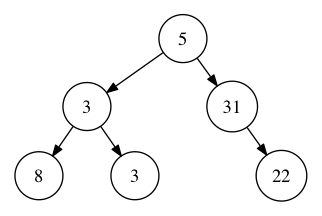

In [252]:
Image("junk.png")

### Lexing

In [267]:
import string
#some code from composing programs
_WHITESPACE = set(' \t\n\r')
_NUMERAL_STARTS = set(string.digits) | set('+-.')
_SINGLE_CHAR_TOKENS = set("()")
_TOKEN_END = _WHITESPACE | _SINGLE_CHAR_TOKENS
_SYMBOL_STARTS = set('%*/+-^') 
_SYMBOL_INNERS = set(string.digits) | set('+-.')

def next_token(expression, pos):
    while pos < len(expression):
        c = expression[pos]
        if c in _WHITESPACE:
            pos += 1
        elif c in _SINGLE_CHAR_TOKENS:
            #print(">c",c)
            return c, (pos + 1)
        else:#a numerical expression or operator
            j = pos
            while j < len(expression) and expression[j] not in _TOKEN_END:
                j += 1
            #print('c>',expression[pos:j])
            return expression[pos:j], min(j, len(expression))
    return None, len(expression)

def valid_symbol(s):
    if len(s) == 0 or s not in _SYMBOL_STARTS:
        return False
    return True

def lex(expression):
    """
    An expression parser
    
    >>> lex('(+ 1 (* 23 3))')
    ['(', '+', 1, '(', '*', 23, 3, ')', ')']
    >>> lex('(+ 1 (* 23 -3))')
    ['(', '+', 1, '(', '*', 23, -3, ')', ')']
    >>> lex('(+ 1 (* 23 -3e03))')
    ['(', '+', 1, '(', '*', 23, -3000.0, ')', ')']
    >>> lex('(+ (* 2 3) (* 23 3))')
    ['(', '+', '(', '*', 2, 3, ')', '(', '*', 23, 3, ')', ')']
    """
    elen = len(expression)
    tokens=[]
    text, i = next_token(expression, 0)
    while text is not None:
        #print(text, expression)
        if text in _SINGLE_CHAR_TOKENS:
            tokens.append(text)
        elif text[0] in _SYMBOL_STARTS and valid_symbol(text):
            tokens.append(text)
        elif text[0] in _NUMERAL_STARTS:
            try:
                tokens.append(int(text))
            except ValueError:
                try:
                    tokens.append(float(text))
                except ValueError:
                    raise ValueError("invalid numeral: {0}".format(text))
        
        text, i = next_token(expression, i)
    return tokens

In [268]:
lex('(+ (* 2 3) (* 23 3))')

['(', '+', '(', '*', 2, 3, ')', '(', '*', 23, 3, ')', ')']

In [269]:
from doctest import run_docstring_examples as dtest
dtest(lex, globals(), verbose=True)

Finding tests in NoName
Trying:
    lex('(+ 1 (* 23 3))')
Expecting:
    ['(', '+', 1, '(', '*', 23, 3, ')', ')']
ok
Trying:
    lex('(+ 1 (* 23 -3))')
Expecting:
    ['(', '+', 1, '(', '*', 23, -3, ')', ')']
ok
Trying:
    lex('(+ 1 (* 23 -3e03))')
Expecting:
    ['(', '+', 1, '(', '*', 23, -3000.0, ')', ')']
ok
Trying:
    lex('(+ (* 2 3) (* 23 3))')
Expecting:
    ['(', '+', '(', '*', 2, 3, ')', '(', '*', 23, 3, ')', ')']
ok


### Syntactic Analysis 

...to get the tree..

In [353]:
def syn(tokens):
    currentTree = None
    stack = []
    for i, c in enumerate(tokens):
        if c == '(':
            if currentTree is not None:
                if currentTree.left is None:
                    ntree = currentTree.addLeftChild(tokens[i+1])
                else:
                    ntree = currentTree.addRightChild(tokens[i+1])
            else:
                ntree = BinaryTree(tokens[i+1])
            stack.append(ntree)
            currentTree = ntree
        elif c in _SYMBOL_STARTS:
            assert currentTree.value == c, "op should follow ("
        elif c not in _SYMBOL_STARTS | _SINGLE_CHAR_TOKENS: #number
            if currentTree.left is None:
                leaf = currentTree.addLeftChild(c)
            else:
                leaf = currentTree.addRightChild(c)
        elif c==')':
            if len(stack) > 1:
                stack.pop()
            currentTree=stack[-1]
    stack.pop()
    return currentTree

In [354]:
t = syn(lex('(+ (* 2 3) (* 23 3))'))

In [355]:
t.value, t.left.value, t.right.value

('+', '*', '*')

In [356]:
syn(lex('(+ 1 (* 23 3))'))

In [357]:
syn(lex('(+ (* 2 3) (* 23 3))'))

In [358]:
plotbtree(syn(lex('(+ (* 2 3) (* 23 3))')), 'exptree')

In [359]:
!cat exptree.dot


    digraph G {
    nodesep=0.3;
    ranksep=0.2;
    margin=0.1;
    node [shape=circle];
    edge [arrowsize=0.8];
    "bbfe2fdd-1421-4110-a176-cf751b4be280" -> "cab113d6-b573-4f9f-ad64-bc10e4bc4a43"[side=left];
"cab113d6-b573-4f9f-ad64-bc10e4bc4a43" -> "8566205e-e79a-4f6c-adb5-2ef19db5ccce"[side=left];
"cab113d6-b573-4f9f-ad64-bc10e4bc4a43" -> "e963e354-5c34-4659-8b52-ac5de7a445bb"[side=right];
"bbfe2fdd-1421-4110-a176-cf751b4be280" -> "774dd054-d177-45c1-a53b-2ebc7a5996ad"[side=right];
"774dd054-d177-45c1-a53b-2ebc7a5996ad" -> "9a40a817-263c-4908-82e0-bcd1584110d9"[side=left];
"774dd054-d177-45c1-a53b-2ebc7a5996ad" -> "834e6310-c6a4-4034-b53f-805d52a24822"[side=right];
"e963e354-5c34-4659-8b52-ac5de7a445bb"[label="3"]
"cab113d6-b573-4f9f-ad64-bc10e4bc4a43"[label="*"]
"8566205e-e79a-4f6c-adb5-2ef19db5ccce"[label="2"]
"774dd054-d177-45c1-a53b-2ebc7a5996ad"[label="*"]
"834e6310-c6a4-4034-b53f-805d52a24822"[label="3"]
"bbfe2fdd-1421-4110-a176-cf751b4be280"[label="+"]
"9a40a817-263c-49

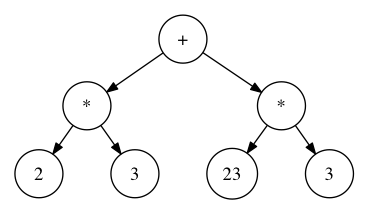

In [360]:
Image('exptree.png')

### Tree traversal

We need to decide how we plan to tracerse the tree. There are 3 choices, based on **an implicit ordering** of the tree from left to right

- In-order: visit left-subtree, then current node, then right sub tree
- Post-order: do child nodes first, and then current node
- Pre-order: do current node, then children

By visit ot do i mean the execution of some operation. For example, consider the filesystem tree. Order does not matter there, but say removing files in a directory before remoc=ving a directory makes sense: this is post-order. similarly to find size of a folder.

Pre-order is rarely used (although we did use it to write a pre-order iterator for the binary tree just now to output stuff in the dot language).

In [361]:
def preorder_traverse(tree, func):
    if tree:
        func(tree.value)
        preorder_traverse(tree.left, func)
        preorder_traverse(tree.right, func)
def inorder_traverse(tree, func):
    if tree:
        inorder_traverse(tree.left, func)
        func(tree.value)
        inorder_traverse(tree.right, func)
def postorder_traverse(tree, func):
    if tree:
        r1=postorder_traverse(tree.left, func)
        r2=postorder_traverse(tree.right, func)
        return func(tree.value, r1, r2)

Ok, so lets support some simple ops...by delegating our "languages" ops to python :-)

In [362]:
from operator import add, sub, mul, pow, mod, truediv
OPDICT={
    '+': add,
    '-': sub,
    '*': mul,
    '/': truediv,
    '%': mod,
    '^': pow
}
def eval_exp(v, x, y):
    if x is not None and y is not None:
        return OPDICT[v](x,y)
    else:
        return v

In [363]:
postorder_traverse(syn(lex('(+ 1 (* 23 3))')), eval_exp)

70

In [364]:
postorder_traverse(syn(lex('(+ 1 (* 23 (/ 1 .3)))')), eval_exp)

77.66666666666667

In [365]:
postorder_traverse(syn(lex('(+ (* 2 3) (* 23 3))')), eval_exp)

75

We'll come back to this calculator next time!

### Priority Queues

People may come to your customer service counter in a certain order, but you might want to serve your executive class first! In other words, there is an "ordering" on your customers, and you want to serve people in the order of the most VIP. This problem requires us to then sort people/items/etc by importance, and then evaluate things in this sorted order.

A priority queue is a data structure for this, that allows us to do things more efficiently than simple sorting every time a new person/item came in.

The basic priority queue is defined to be supporting three primary operations:

- Insert: insert an item with "key" (an importance, say) k into priority queue Q. 
- Find Minimum: get the item or a pointer to the item whose key value is smaller than any other key in Q. 
- Delete Minimum: Remove the item with minimum k from Q 

So, how would we implemen a priority queue. One way to do it is to use an unsorted array. 

We can additionally store a pointer to the minimum index, so that minimum is an O(1) operation. This pointer is easily updated on a new insert into the array because we update it in O(1) only when the new value is less than the current one on a comparision. what happens on deleting a minimum value? To find a new minimum we must scan our array in O(n), and then reset the pointer.

If we now replace the underlying implementation of a priority queue by a balanced binary tree structure, we can expect the complexity to go down to lg(n).

One such example of a balanced binary tree structure is a heap. A heap which does minimums is called a **min-heap**. Similarly you can define a **max-heap"**. You cant do min and max together in one data structure.

We can now use such a priority queue implementation to speed up selection sort from $O(n^{2})$ to $O(nlog(n))$. The name given to this algorithm is heapsort, which makes it sound like something wierd, but it is just an implementation of selection sort using the right data structure. And indeed it is an in-place place sort, so no extra memory is used: O(1) additional space complexity.

### Heaps

The heap mantains a partial order on the data rather than the full ordering sorting does. As a result they are more efficient to maintain; but not random like an array, so that the minimum cab be quickly obtained.

A heap has 2 properties:

#### Shape property

A leaf node at depth $k>0$ can exist only if all the nodes at the previous depth exist. Nodes at any partially filled level are added “from left to right.” (although we practically add this to all levels, not just partially filled ones for simplicity.

#### Heap property

Each node in the tree contains a key less than or equal to either of its two children, if it has any. This makes it a **min-heap**. This is also known a the jey labelling of a "parent node" dominating that of its children. For max heaps we use greater-than-or-equal.

It would seem that the simplest implementation of this tree would be to use the BinaryTree class we created earlier. But since in all binary trees, the size of pointer dats might be higher than that of the key payloads, one can ask if there are simpler ways to represent the tree.

Indeed for heaps we can do this usefully. The first element in the array is the root key. The next two the first level of children, from left to right. Then the next four and so on. 

Now, to construct our heap, we will insert each new element that comes in at the left-most open spot. This maintains the shape property, but not the Heap property of a parent's dominance over its children.

To restore the heap property, we look upwards at the parent, and if the child "dominates" we swap parent and child. This procedure will ensure that the simpling will also be dominated. We then repeat this process until we bubble up to the root.

Identifying the dominant (or the min or the max) is now easy as it is at the top of the tree. But if we remove the dominant key, there is some work to be done, as we have a hole at the top (the first position in the array.

We now fill this hole with the rightmost position in the array, or the rightmost leaf node. This destroys the heap property. So we now bubble this key down instead until it dominates all its children, perhaps by becoming a leaf.

This process is called **heapify** and must also be done at the firat construction of the heap.

### But first, some code to draw the heap

You can safely skip this, but I included it here as you might find it useful in your own work later.

In [331]:
import subprocess
from IPython.display import Image
def dotify(l, fname):
    start = """
    digraph G {
    nodesep=0.3;
    ranksep=0.2;
    margin=0.1;
    node [shape=circle];
    edge [arrowsize=0.8];
    """
    end = "}"
    labels=dict(enumerate(l))
    for i, v in labels.items():
        if i!=0 and 2*i < len(l):
            line1 = "{} -> {}[side=left];\n".format(i, 2*i)
        else:
            line1=""
        if i!=0 and 2*i + 1 < len(l):
            line2 = "{} -> {};\n".format(i, 2*i+1)
        else:
            line2 = ""
        start = start + line1 + line2
    end = "\n".join("{}[label=\"{}\"]".format(i, labels[i]) for i in labels if i!=0) + end
    with open(fname+".dot","w") as fd:
        fd.write(start+end)
    subprocess.call(['./treeplot.sh', fname])

In [332]:
class BinaryHeap:
    def __init__(self, storage = None):
        if storage:
            self.storage = [None]+list(storage)
            self.upto = len(storage)
        else:
            self.storage=[None]
            self.upto = 0
        
    @classmethod
    def heapify_slow(cls, it):
        inst = cls()
        for i in it:
            inst.insert(i)
        return inst
    
    def make_heap(self):
        for i in range(1,self.upto + 1):
            dotify(self.storage, "img"+str(i).zfill(2))
            self.sift_up(i)
            dotify(self.storage, "img"+str(i).zfill(2)+'_a')
        
    def insert(self, value):
        self.storage.append(value)
        self.upto += 1
        dotify(self.storage, "img"+str(self.upto).zfill(2))
        self.sift_up(self.upto)
        dotify(self.storage, "img"+str(self.upto).zfill(2)+'_a')

    def sift_up(self, i):
        parent = i // 2
        if parent > 0 and self.storage[i] < self.storage[parent]:
            self.storage[i], self.storage[parent] = self.storage[parent], self.storage[i]
            self.sift_up(parent)
            
    def min(self):
        return self.storage[1]

In [333]:
list(range(1,11))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [334]:
inputlist = [None, 1,8,5,9,23,2,45,6,7,99,-5]
dotify(inputlist, "input")

In [335]:
!cat input.dot


    digraph G {
    nodesep=0.3;
    ranksep=0.2;
    margin=0.1;
    node [shape=circle];
    edge [arrowsize=0.8];
    1 -> 2[side=left];
1 -> 3;
2 -> 4[side=left];
2 -> 5;
3 -> 6[side=left];
3 -> 7;
4 -> 8[side=left];
4 -> 9;
5 -> 10[side=left];
5 -> 11;
1[label="1"]
2[label="8"]
3[label="5"]
4[label="9"]
5[label="23"]
6[label="2"]
7[label="45"]
8[label="6"]
9[label="7"]
10[label="99"]
11[label="-5"]}

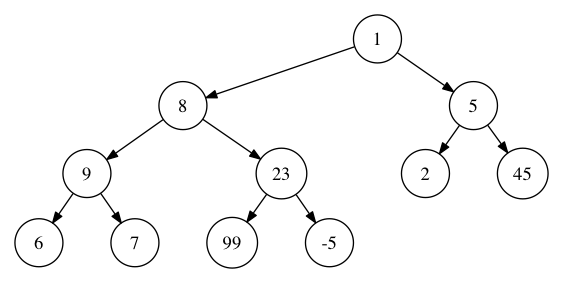

In [336]:
Image("input.png")

In [337]:
bh = BinaryHeap([1,8,5,9,23,2,45,6,7,99,-5])
bh.make_heap()

In [338]:
!montage -geometry 300x150 -tile 2x11 img*.png out.png

montage: unable to read font `(null)' @ error/annotate.c/RenderFreetype/1152.


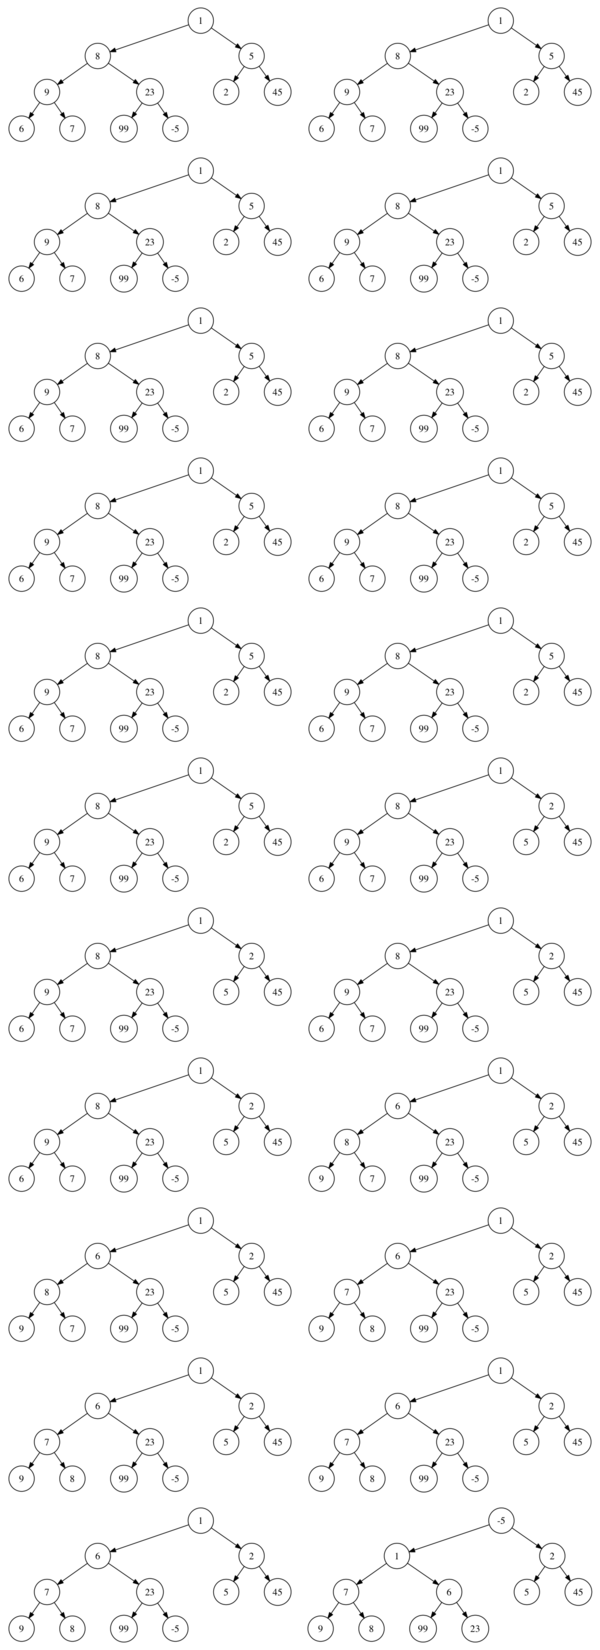

In [339]:
Image("out.png")

In [340]:
dotify(bh.storage, "heap")

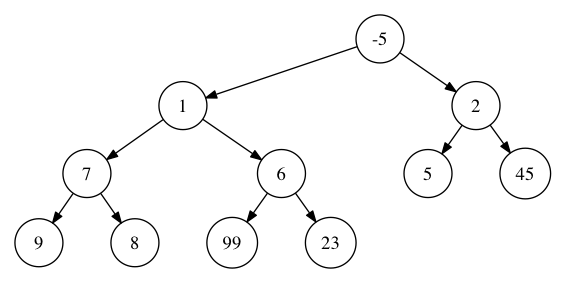

In [341]:
Image("heap.png")

### Deleting the minimum

We'll eliminate the instrument and existing storage code to simplify..., but instrument the deletion process

In [342]:
class BinaryHeap:
    def __init__(self):
        self.storage=[None]
        self.upto=0
        
    @classmethod
    def heapify_slow(cls, it):
        inst = cls()
        for i in it:
            inst.insert(i)
        return inst
            
    def insert(self, value):
        self.storage.append(value)
        self.upto += 1
        self.sift_up(self.upto)

    def sift_up(self, i):
        parent = i // 2
        if parent > 0 and self.storage[i] < self.storage[parent]:
            self.storage[i], self.storage[parent] = self.storage[parent], self.storage[i]
            self.sift_up(parent)
     
    def _min_child(self, i):
        if 2*i + 1 > self.upto:
            return 2*i
        else:
            l = (self.storage[2*i], self.storage[2*1+1])
            return 2*i + l.index(min(l))
    
    def sift_down(self, i):
        dotify(self.storage, "delimg"+str(i).zfill(2))
        if 2*i <= self.upto:
            child = self._min_child(i)
            if self.storage[i] > self.storage[child]:
                self.storage[child], self.storage[i] = self.storage[i], self.storage[child]
                self.sift_down(child)
        
    def min(self):
        return self.storage[1]
    
    def delmin(self):
        minval = self.storage[1]
        self.storage[1], self.storage[self.upto] = self.storage[self.upto], self.storage[1]
        self.storage.pop()
        self.upto -= 1
        self.sift_down(1)
        return minval

In [343]:
bh = BinaryHeap.heapify_slow([1,8,5,9,23,2,45,6,7,99,-5])
print(bh.storage)
bh.min()

[None, -5, 1, 2, 7, 6, 5, 45, 9, 8, 99, 23]


-5

In [344]:
bh.delmin()

-5

In [345]:
bh.storage

[None, 1, 6, 2, 7, 23, 5, 45, 9, 8, 99]

In [346]:
!montage -geometry 600x300 -tile 1x4 img*.png delmin.png

montage: unable to read font `(null)' @ error/annotate.c/RenderFreetype/1152.


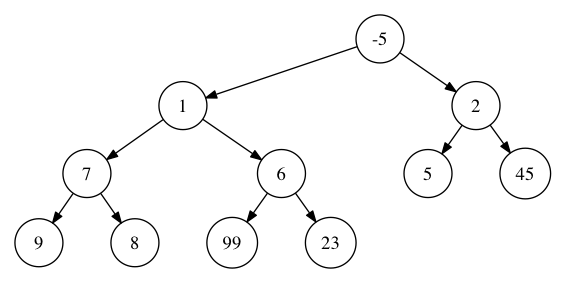

In [347]:
Image("heap.png")

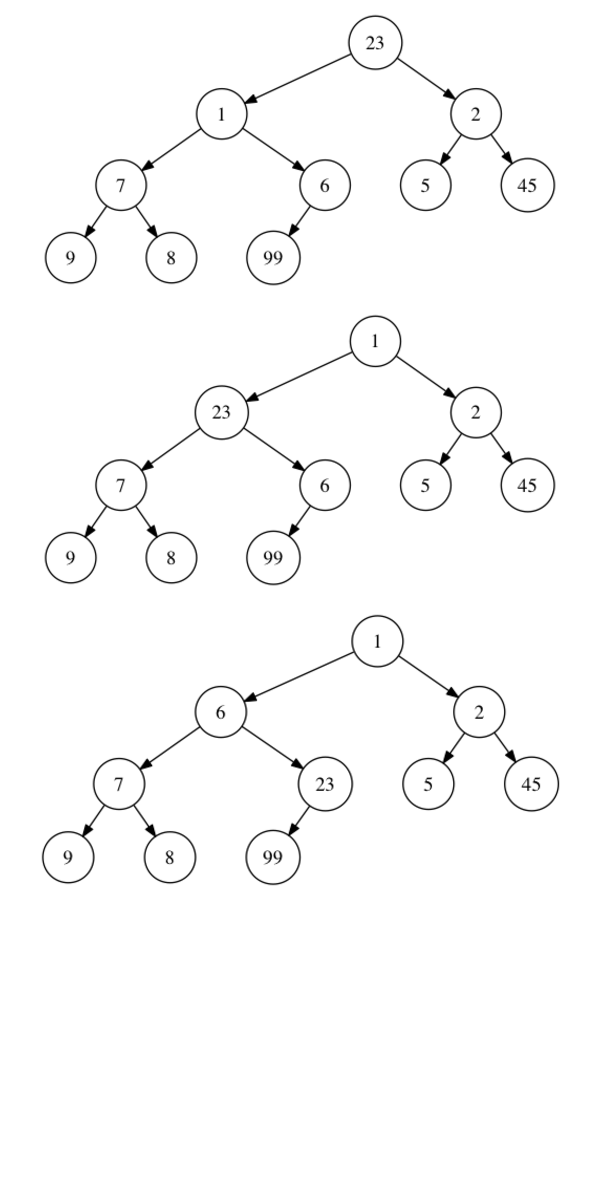

In [348]:
Image("delmin.png")

### An O(n) heapify to construct the heap from the list

In [370]:
class BinaryHeap:
    def __init__(self):
        self.storage=[None]
        self.upto=0
        
    @classmethod
    def heapify_slow(cls, it):
        inst = cls()
        for i in it:
            inst.insert(i)
        return inst
       
    @classmethod
    def heapify(cls,it):
        inst = cls()
        inst.storage = inst.storage + list(it)
        fromhalfway = (len(inst.storage) - 1) // 2
        inst.upto = len(inst.storage) - 1
        counter = 0
        while (fromhalfway > 0):
            dotify(inst.storage, "onheapifyimg"+str(counter).zfill(2))
            counter += 1
            inst.sift_down(fromhalfway)
            fromhalfway -= 1
        dotify(inst.storage, "onheapifyimg"+str(counter).zfill(2))
        return inst
        
        
    def insert(self, value):
        self.storage.append(value)
        self.upto += 1
        self.sift_up(self.upto)

    def sift_up(self, i):
        parent = i // 2
        if parent > 0 and self.storage[i] < self.storage[parent]:
            self.storage[i], self.storage[parent] = self.storage[parent], self.storage[i]
            self.sift_up(parent)
     
    def _min_child(self, i):
        if 2*i + 1 > self.upto:
            return 2*i
        else:
            l = (self.storage[2*i], self.storage[2*i+1])
            return 2*i + l.index(min(l))
    
    def sift_down(self, i):
        if 2*i <= self.upto:
            child = self._min_child(i)
            if self.storage[i] > self.storage[child]:
                self.storage[child], self.storage[i] = self.storage[i], self.storage[child]
                self.sift_down(child)
        
    def min(self):
        return self.storage[1]
    
    def delmin(self):
        minval = self.storage[1]
        self.storage[1], self.storage[self.upto] = self.storage[self.upto], self.storage[1]
        self.storage.pop()
        self.upto -= 1
        self.sift_down(1)
        return minval


In [371]:
bh = BinaryHeap.heapify([1,8,5,9,23,2,45,6,7,99,-5])
print(bh.storage)
bh.min()

[None, -5, 1, 2, 6, 8, 5, 45, 9, 7, 99, 23]


-5

In [368]:
!montage -geometry 600x300 -tile 1x6 onheapifyimg*.png onheapify.png

montage: unable to read font `(null)' @ error/annotate.c/RenderFreetype/1152.


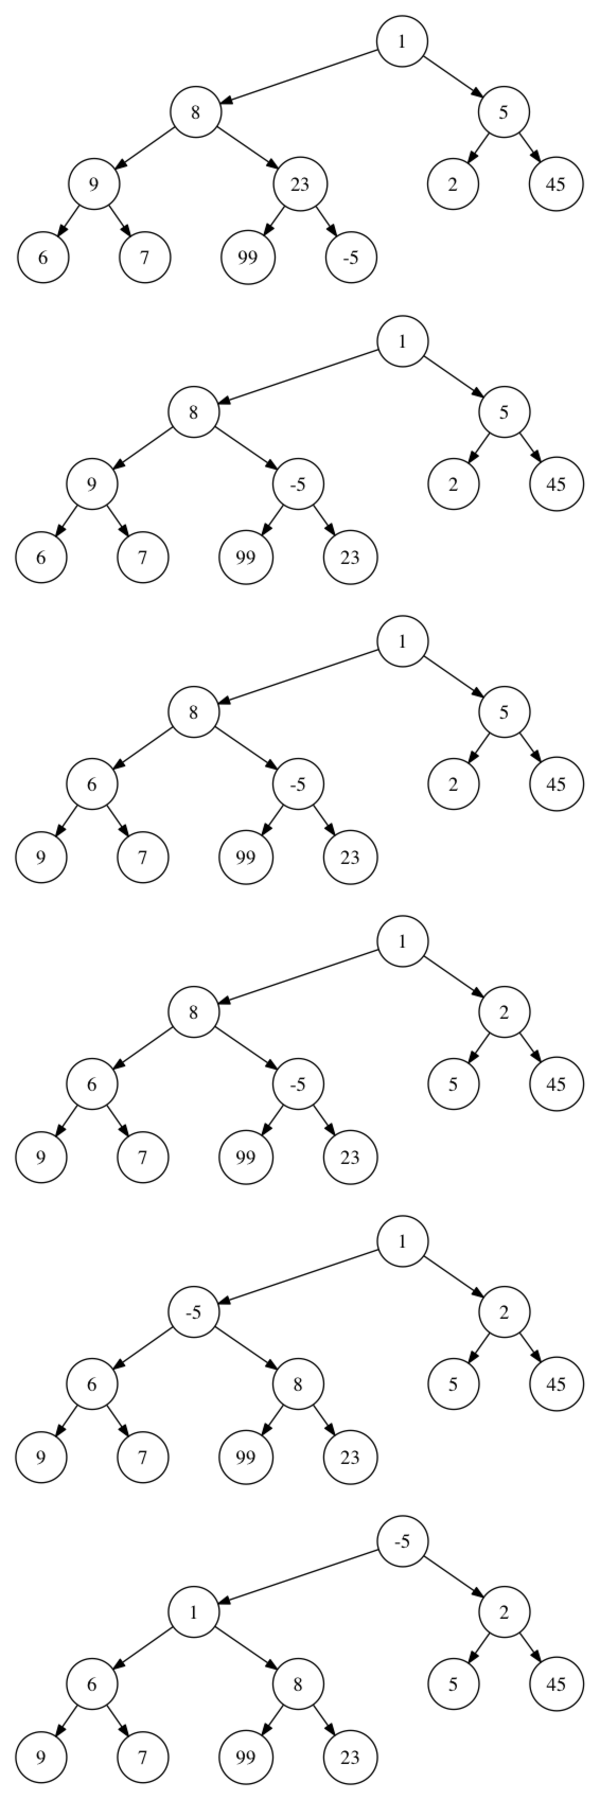

In [369]:
Image("onheapify.png")